# Introduction
In this section, our task is divided into two parts.   

In the first part, we download all quantitative datasets from the SEC official website(https://www.sec.gov/dera/data/financial-statement-data-sets.html). Then we propose and perform an automatic labelling strategy on these quantitative data to obtain labels for subsequent supervised learning tasks. We also create a Central Index Key (CIK) code list which will be used in annual report processing part.    

In the second part, we develop scraper with *requests* and *BeautifulSoup*. We scrape '10-K' and '20-F' type annual statements from 2000 to 2022 of companies in CIK code list. Then we clean and normalise the text from scrapings so that they are easier to be analysed. What worth a mentioning is that multi-processing technology is used to speed up the processing. At last, we perform some Natural Language Processing operations on example texts and provide the visualization of results.

Note:     
Some code cells need more RAM than colab provided and some code cells have very long run time. (I mark them with 'need more RAM' and 'long run time' in comment).     
Here are links to the processed data:     
https://drive.google.com/drive/folders/1EHKN0kt0rCrwB_l_xRRRWvG8zTy3FFEw?usp=share_link   
https://drive.google.com/drive/folders/11PB8Plrxr2jLLmI29Y6RRhPJ3l4HRXzS?usp=share_link

If you want to run other code cells, you can copy needed files or entire folder to your google drive and load them using code cells I provided in this notebook. Contact e0925558@u.nus.edu if you can't access contents in above links.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1. Quantitative Data Processing

In [ ]:
## Set Up
import os
import zipfile
from cmath import nan
import pandas as pd
import matplotlib.pyplot as plt

### a. Download datasets from SEC

SEC updates datasets every quarter since 2009. These datasets provide numerical financial performance indicators(e.g. Net Operating Income, Revenue) extracted from all corporate financial statements filed with the SEC and presented them in a flattened and compact format. 

In [ ]:
# create a download link file
baselink = 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/'
year = [i for i in range(2009, 2023)]
links = []
for i in range(2009, 2023):
  for j in range(1,5):
    if (i == 2022) & (j == 4):
      continue
    link = baselink + str(i) + 'q' + str(j) + '.zip'
    links.append(link)
with open('links.txt','w') as f:
  f.write('\n'.join(links))

# download datasets
zippath = 'zipdata'
if not os.path.exists(zippath):
  os.mkdir(zippath) 
  !wget -q -P zipdata -i links.txt

In [ ]:
# unzip datasets
datapath = 'data'
if not os.path.exists(datapath):
  os.mkdir(datapath) 

  filenames = os.listdir(zippath)
  for filename in filenames:
      filepath = os.path.join(zippath,filename)
      if os.path.isfile(filepath):
        zip_file = zipfile.ZipFile(filepath)
        newfilepath = filename.split(".",1)[0]
        newfilepath = os.path.join(datapath,newfilepath)
        if os.path.isdir(newfilepath):
            pass
        else:
            os.mkdir(newfilepath)
        for name in zip_file.namelist():
            zip_file.extract(name,newfilepath)
        zip_file.close()

In [ ]:
# 
datapath = 'data'
filename = os.listdir(datapath)
filename = sorted(filename)
print(f'{len(filename)} financial statement datasets are downloaded:')
print(filename)
print('\nThe structure of each dataset is')
print(os.listdir(datapath + '/' + filename[0]))

55 financial statement datasets are downloaded:
['2009q1', '2009q2', '2009q3', '2009q4', '2010q1', '2010q2', '2010q3', '2010q4', '2011q1', '2011q2', '2011q3', '2011q4', '2012q1', '2012q2', '2012q3', '2012q4', '2013q1', '2013q2', '2013q3', '2013q4', '2014q1', '2014q2', '2014q3', '2014q4', '2015q1', '2015q2', '2015q3', '2015q4', '2016q1', '2016q2', '2016q3', '2016q4', '2017q1', '2017q2', '2017q3', '2017q4', '2018q1', '2018q2', '2018q3', '2018q4', '2019q1', '2019q2', '2019q3', '2019q4', '2020q1', '2020q2', '2020q3', '2020q4', '2021q1', '2021q2', '2021q3', '2021q4', '2022q1', '2022q2', '2022q3']

The structure of each dataset is
['tag.txt', 'num.txt', 'sub.txt', 'pre.txt', 'readme.htm']


### b. Perform Indicator Labelling Strategy 

1. Count the record number of each financial performance indicator and sort the count number. Choose suitable indicators from top15 for later use. Here, we choose "NetIncomeLoss", "OperatingIncomeLoss", "Revenues".   
2. Every financial statements has an unique Accession Number (adsh) assigned by the SEC. Every company has an unique Central Index Key (cik) code. Create a mapping table to record their correspondence.    
3. Extract annual data records that contain chosen indicators.  
4. Change data format. Merge 3 indicator values and their units of measurement for the same company and the same submission date into one cell.    
5. Calculate the growth rate of each indicator in adjacent years. Set 2 positive cut-off values and 2 negative cut-off values (c4 < c3 < 0 < c2 < c1).  Label the previous year according to principles shown in the following table.     
6. Adjust cut-off values to balance the number of each label.    

| condition | label |
| :------: | :------: |
| all not-nan indicator growth rates >= c1 | 2 |
| all not-nan indicator growth rates >= c2 & at least one rate < c1 | 1 |
| all not-nan indicator growth rates <= c4 | -2 |
| all not-nan indicator growth rates <= c3 & at least one rate > c4 | -1 |
| other conditions | 0 |


In [ ]:
## Count indicator number
def indicator_count(file_dir):
  folder_dir = os.listdir(file_dir)  # list all folder under 'data'
  merge_list = []  # path of all num.txt
  for folder in folder_dir:
    if folder == ".DS_Store": 
      continue
    num_df = pd.read_table(os.path.join(file_dir, folder, "num.txt"),dtype={"coreg": str, "footnote": str})
    num_df["foldername"] = folder
    merge_list.append(num_df)

  df = pd.concat(merge_list, ignore_index = True)  # concatenate all num.txt
  
  # count record number of each indicator
  tag_count = {}
  for index,row in df.iterrows():
      tag = row["tag"]
      if tag in tag_count:
          tag_count[tag] = tag_count[tag] + 1
      else:
          tag_count[tag] = 1
  return tag_count

In [ ]:
# need more RAM

datapath = 'data'
count = indicator_count(datapath)

# save results
tagcount_df = pd.DataFrame.from_dict(count, orient='index')
tagcount_df.index.name = "tag"
tagcount_df.columns = ["count"]
tagcount_df = tagcount_df.sort_values(by=['count'], ascending=False)
tagcount_df.to_csv("tag_count.csv", index = True)

In [ ]:
tagcount_df = pd.read_csv('/content/drive/My Drive/financial_data_processing/tag_count.csv')
tagcount_df[:15]

,tag,count
0,NetIncomeLoss,1376187
1,CashAndCashEquivalentsAtCarryingValue,1188427
2,OperatingIncomeLoss,1017524
3,IncomeTaxExpenseBenefit,955886
4,StockholdersEquity,955314
5,Assets,794394
6,LiabilitiesAndStockholdersEquity,755426
7,InterestExpense,748453
8,EarningsPerShareBasic,747753
9,EarningsPerShareDiluted,724054


We choose 3 indicators for later use. Here is the meaning of them.
* NetIncomeLoss: Net Income (Loss) Attributable to Parent. The portion of profit or loss for the period, net of income taxes, which is attributable to the parent. 

* OperatingIncomeLoss: Operating Income (Loss).	The net result for the period of deducting operating expenses from operating revenues. 

* Revenues: Amount of revenue recognized from goods sold, services rendered, insurance premiums, or other activities that constitute an earning process. Includes, but is not limited to, investment and interest income before deduction of interest expense when recognized as a component of revenue, and sales and trading gain (loss).


In [ ]:
## Extract records that contains chosen records
def extract_data(file_dir,tags):
  folder_dir = os.listdir(file_dir)  # list all folder under 'data'
  merge_list = []  # path of all num.txt
  for folder in folder_dir:
    if folder == ".DS_Store": 
      continue
    num_df = pd.read_table(os.path.join(file_dir, folder, "num.txt"),dtype={"coreg": str, "footnote": str})
    num_df["foldername"] = folder
    merge_list.append(num_df)

  df = pd.concat(merge_list, ignore_index = True)  # concatenate all num.txt
  selecteddf = df.loc[(df["tag"].isin(tags)) & (df["qtrs"] == 4), ["adsh", "foldername", "ddate", "qtrs", "tag","uom", "value"]]  # select needed rows and columns
  newdf = selecteddf.dropna(axis = 0)  # remove rows that contain NaNs values
  newdf = newdf.drop(newdf[newdf.value == 0.0].index)  # remove rows that value == 0.0
  sorted_df = newdf.sort_values(by = ["tag","foldername"])  # sort
  return sorted_df

In [ ]:
# need more RAM

datapath = 'data'
indicators = sorted(["NetIncomeLoss", "OperatingIncomeLoss", "Revenues"]) # indicators we chose.
print(indicators)
sorted_df = extract_data(datapath,indicators)
# save results
sorted_df.to_csv("part1_records.csv", index = False)

In [ ]:
sorted_df = pd.read_csv("/content/drive/My Drive/financial_data_processing/annual_data/part1_records.csv")
sorted_df

,adsh,foldername,ddate,qtrs,tag,uom,value
0,0000038074-09-000029,2009q2,20070331,4,NetIncomeLoss,USD,4.541030e+08
1,0000038074-09-000029,2009q2,20080331,4,NetIncomeLoss,USD,9.679330e+08
2,0000038074-09-000029,2009q2,20090331,4,NetIncomeLoss,USD,7.677430e+08
3,0001193125-09-154174,2009q3,20090630,4,NetIncomeLoss,USD,6.630000e+08
4,0001193125-09-154174,2009q3,20080630,4,NetIncomeLoss,USD,5.880000e+08
...,...,...,...,...,...,...,...
600083,0001599916-22-000252,2022q3,20220430,4,Revenues,USD,6.950236e+06
600084,0001599916-22-000252,2022q3,20210430,4,Revenues,USD,3.983860e+05
600085,0001628280-22-022584,2022q3,20220630,4,Revenues,USD,1.397400e+10
600086,0001628280-22-022584,2022q3,20210630,4,Revenues,USD,1.290900e+10


In [ ]:
## Build adsh-cik map table
def adsh_cik(file_dir):
  folder_dir = os.listdir(file_dir)  # list all folder under data
  sub_merge_list = []  # path of all sub.txt

  for folder in folder_dir:
    if folder == ".DS_Store": 
      continue
    sub_df = pd.read_table(os.path.join(file_dir, folder, "sub.txt"), dtype={"aciks": str})
    sub_df["foldername"] = folder
    sub_merge_list.append(sub_df)
  
  sub_df = pd.concat(sub_merge_list, ignore_index = True)  # concatenate all sub.txt
  sub_df = sub_df[["adsh", "cik"]]

  return sub_df

In [ ]:
# need more RAM
 
sub_df = adsh_cik(datapath)
# save results
sub_df.to_csv("adsh_cik.csv", index = False)

In [ ]:
sub_df = pd.read_csv("/content/drive/My Drive/financial_data_processing/adsh_cik.csv")
sub_df

,adsh,cik
0,0000009389-21-000078,9389
1,0000037996-21-000020,37996
2,0000038009-21-000033,38009
3,0000038725-21-000080,38725
4,0000048732-21-000004,48732
...,...,...
482022,0001213900-11-005361,1487906
482023,0001264931-11-000548,1320729
482024,0001354488-11-003644,1477776
482025,0001393905-11-000685,1365784


In [ ]:
## Change data format. merge into on cell.
def merge(x, tags):
  data = x.iloc[0, [-1, 2]]
  val = [['_'] * len(tags), ['_'] * len(tags)]  # "_": no value
  
  x_tags = x["tag"].values
  x_vals =x["value"].values
  x_uoms = x["uom"].values
  for i in range(len(x_tags)):
      tag_index = tags.index(x_tags[i])
      val[0][tag_index] = x_vals[i]
      val[1][tag_index] = x_uoms[i]
  data["val"] = tuple(val)
  return data

def change_format(sorted_df, sub_df, tags):
  sub_df.index = sub_df["adsh"].values
  sorted_df["cik"] = sorted_df["adsh"].map(lambda x : sub_df.at[x, "cik"]) # add "cik" column

  dropdup_df = sorted_df.drop_duplicates(subset = ["cik","ddate","qtrs","tag"], keep = "last")  # drop duplication
  newdf1 = dropdup_df.groupby(["cik","ddate"]).apply(lambda x : merge(x, tags)) # merge data into a tuple
  # newdf1 = newdf1.dropna(axis = 0)  # drop rows with nan
  newdf2 = newdf1.drop(newdf1[newdf1.ddate < 20080101].index)
  newdf2 = newdf2.drop(newdf2[newdf2.ddate > 20220930].index)
  res = newdf2.set_index(["cik", "ddate"])["val"].unstack() # change format
  res.columns.name = None
  res = res.reset_index()

  return res

In [ ]:
indicators = sorted(["NetIncomeLoss", "OperatingIncomeLoss", "Revenues"])
result = change_format(sorted_df, sub_df,indicators)
# save results
result.to_csv('part2_tuple_data.csv', index=False)

In [ ]:
company_number = result.shape[0]
non_nan = result.notna().sum().sum()
print(f'The number of companies is {company_number}.')
print(f'The time span is {2022 - 2008 + 1} years.')
print(f'The number of non-nan values is {non_nan}')
print(f'Average number of valid annual data for each company is {non_nan / company_number}.\n')
result

The number of companies is 13245.
The time span is 15 years.
The number of non-nan values is 110395
Average number of valid annual data for each company is 8.334843337108342.



,cik,20080131,20080229,20080331,20080430,20080531,20080630,20080731,20080831,20080930,...,20211031,20211130,20211231,20220131,20220228,20220331,20220430,20220531,20220630,20220731
0,1750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"([78700000.0, _, _], [USD, _, _])",NaN,NaN
1,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"([7071000000.0, 8425000000.0, _], [USD, USD, _])",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"([-614170.0, -1865204.0, _], [USD, USD, _])",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"([13655679.0, 12769987.0, 182087559.0], [USD, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13240,1912838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"([-65280.0, _, 8137.0], [USD, _, USD])",NaN,NaN,NaN,NaN,NaN,NaN,NaN
13241,1913838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"([-9143.0, _, _], [USD, _, _])",NaN
13242,1915654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"([312118.0, -282666.0, _], [USD, USD, _])",NaN,NaN,NaN,NaN,NaN,NaN,NaN
13243,1915657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"([558324000.0, 749186000.0, 18389142000.0], [U...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## label data
def label(data, tags, divide_line, year1):
    label = pd.DataFrame(index = data.index, columns = data.columns) # initial
    label["cik"] = data["cik"]
    tag_number = len(tags)
    
    for index, row in data.iterrows(): # iterate every row
        for col in range(13, row.shape[0]): 
            val = [['_'] * tag_number for i in range(year1)]  # store growth rate

            continue_flag = False
            for i in range(year1 + 1): 
                if pd.isna(row.iloc[col + 12 * (i - 1)]): # if value is nan
                    continue_flag = True
                    break
            if continue_flag:
                continue
            
            # calculate the growth rate
            for i in range(year1):
                a = row.iloc[col + 12 * (i - 1)]  # previous year's value
                b = row.iloc[col + 12 * i] 

                for j in range(tag_number): 
                    if (a[0][j] == '_') or (b[0][j] == '_'): # no value
                        continue
                    if a[1][j] != b[1][j]:  # different uom 
                        continue
                    if a[0][j] != 0:
                        val[i][j] = 100 * (b[0][j] - a[0][j]) / abs(a[0][j])
                    else:
                        val[i][j] = 100 * (b[0][j] - a[0][j])
            
            # label 0
            complete_col = []
            for k in range(tag_number):
                complete_flag = True
                for i in range(year1):
                    if val[i][k] == '_':
                        complete_flag = False
                        break
                if complete_flag:
                    label.iloc[index, col] = 0
                    complete_col.append(k)

            if len(complete_col) == 0: 
                continue

            # label other value
            for k in complete_col:
                if val[0][k] >= divide_line[2]:
                    flag = True
                    for i in range(1, year1):
                        if val[i][k] < divide_line[2]:
                            flag = False
                            break
                    if flag:
                        label.iloc[index, col] = 1
                        flag2 = True
                        for i in range(year1):
                            if val[i][k] < divide_line[3]:
                                flag2 = False
                                break
                        if flag2:
                            label.iloc[index, col] = 2
                        break    
                elif val[0][k] <= divide_line[1]:
                    flag = True
                    for i in range(1, year1):
                        if val[i][k] > divide_line[1]:
                            flag = False
                            break
                    if flag:
                        label.iloc[index, col] = -1
                        flag2 = True
                        for i in range(year1):
                            if val[i][k] > divide_line[0]:
                                flag2 = False
                                break
                        if flag2:
                            label.iloc[index, col] = -2
                        break

    return label

In [ ]:
cutoff_values = [-90, -20, 30, 90]  ## adjust there cut-off values to balance the number for each label

label_res = label(result, indicators, cutoff_values, year1 = 1)

label_res.to_csv("part3_label_data.csv", index = False)

In [ ]:
label_res

,cik,20080131,20080229,20080331,20080430,20080531,20080630,20080731,20080831,20080930,...,20211031,20211130,20211231,20220131,20220228,20220331,20220430,20220531,20220630,20220731
0,1750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
1,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13240,1912838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13241,1913838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,NaN
13242,1915654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13243,1915657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


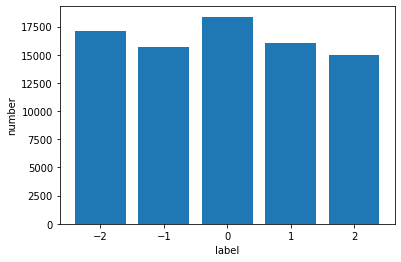

Total label number is 82254


In [ ]:
## count the number of each label
count = [0] * 5
for index, row in label_res.iterrows(): 
    for col in range(row.shape[0]):
        if pd.isna(row.iloc[col]):
            continue

        if row.iloc[col] == -2:
            count[0] += 1
        elif row.iloc[col] == -1:
            count[1] += 1
        elif row.iloc[col] == 0:
            count[2] += 1
        elif row.iloc[col] == 1:
            count[3] += 1
        elif row.iloc[col] == 2:
            count[4] += 1
plt.bar([-2,-1,0,1,2], count)

plt.xlabel('label')
plt.ylabel('number')

plt.show()
print(f'Total label number is {sum(count)}')

### c. Collect Central Index Key (CIK) code


In [ ]:
cik_set = set()
df = pd.read_csv("/content/drive/My Drive/financial_data_processing/adsh_cik.csv")
# df = pd.read_csv("adsh_cik.csv")
res = ""

for index, row in df.iterrows():
    a = str(row['cik'])
    a = a.zfill(10)
    if a in cik_set:
        continue
    res = res + a + ","
    cik_set.add(str(a))
print(cik_set)

file = open('cik.txt','w')
file.write(res)
file.close()

## Part 2. Annual Report Processing

In [ ]:
## Set Up
import numpy as np
import random
import time
  
import requests
from bs4 import BeautifulSoup

import unicodedata
import re

import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
## Set Parameters
form_type_list = ['10-K','20-F']
filings_start_date = '20000101'
filings_end_date = ''

hdr = {'User-Agent':'xuejingcc@gmail.com', 'Host': 'www.sec.gov'}

### a. Scrape Annual Report

I develop scraper with *requests* and *BeautifulSoup*. I first scrape some key information relating to each company's annual statements, including accession number, company name, filing date, filing type, and links to each statement. Then I scrape the content from direct links with htm or txt suffixes and only keep the annual statement text by removing HTML tags. Finally, 168,707 '10-K' or '20-F' type annual statements spanning from 2000 to 2022 for 15,339 companies is obtained.

In [ ]:
## Read cik list
# f2 = open("cik.txt","r")
f2 = open("/content/drive/My Drive/annual_report_processing/new/cik.txt","r")
lines = f2.readlines()
f2.close()
CIK_codes = lines[0].split(',')
CIK_codes.pop()
print(len(CIK_codes))

15339


In [ ]:
# long run time

## Scrape key information relating to each company's filings
endpoint = 'https://www.sec.gov/cgi-bin/browse-edgar/'
master_dict = {}
count = 0
cik_count = 0
for CIK in CIK_codes:
  for form_type in form_type_list:
    params_dict = {'action':'getcompany',
                  'CIK':str(CIK),
                  'type':form_type,
                  'datea':filings_start_date,
                  'dateb':filings_end_date,
                  'owner':'include',
                  'output':'atom'
                  }
    response = requests.get(url=endpoint,params=params_dict,headers=hdr)
    count += 1
    if count % 8 == 0:
      time.sleep(1)
    soup = BeautifulSoup(response.content, 'lxml')
    entries = soup.find_all('entry')
    for entry in entries:
      entry_dict = {}

      entry_dict['company_name'] = soup.find('conformed-name').text
      entry_dict['cik'] = CIK
      entry_dict['filing_date'] = entry.find('filing-date').text
      entry_dict['filing_type'] = entry.find('filing-type').text
      entry_dict['filing_index_href'] = entry.find('filing-href').text

      accession_number = entry.find('accession-number').text
      master_dict[accession_number] = entry_dict   # use the accession number of each statement as key in master dictionary  
  cik_count += 1
  if cik_count % 1000 == 0:
      print(f'done with {cik_count} companies')
      df = pd.DataFrame.from_dict(master_dict, orient='index')
      df.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part1.csv')
print(f'done with {cik_count} companies')
df = pd.DataFrame.from_dict(master_dict, orient='index')
df.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part1.csv')

done with 15000 companies
done with 15339 companies


In [ ]:
part1_data = pd.read_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part1.csv',index_col=0)
print(f'The number of annual statements is {part1_data.shape[0]}.')
part1_data

The number of annual statements is 168707.


,company_name,cik,filing_date,filing_type,filing_index_href
0001558370-22-001251,BALL Corp,9389,2022-02-16,10-K,https://www.sec.gov/Archives/edgar/data/9389/0...
0001558370-21-001121,BALL Corp,9389,2021-02-17,10-K,https://www.sec.gov/Archives/edgar/data/9389/0...
0001558370-20-001005,BALL Corp,9389,2020-02-19,10-K,https://www.sec.gov/Archives/edgar/data/9389/0...
0001558370-19-000909,BALL Corp,9389,2019-02-22,10-K,https://www.sec.gov/Archives/edgar/data/9389/0...
0001558370-18-001345,BALL Corp,9389,2018-03-01,10-K,https://www.sec.gov/Archives/edgar/data/9389/0...
...,...,...,...,...,...
0001193125-12-070198,"NX Global, Inc",1165336,2012-02-21,10-K,https://www.sec.gov/Archives/edgar/data/116533...
0001193125-11-064109,"NX Global, Inc",1165336,2011-03-11,10-K,https://www.sec.gov/Archives/edgar/data/116533...
0001193125-10-207926,"NX Global, Inc",1165336,2010-09-10,10-K/A,https://www.sec.gov/Archives/edgar/data/116533...
0001193125-10-032037,"NX Global, Inc",1165336,2010-02-16,10-K,https://www.sec.gov/Archives/edgar/data/116533...


In [ ]:
# split 168707 annual statements into three parts
df1 = df[:60000]
df2 = df[60000:120000]
df3 = df[120000:]
df1.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part1_1.csv')
df2.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part1_2.csv')
df3.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part1_3.csv')

In [ ]:
# long run time

## Scrape direct links to filings
part1_data = pd.read_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part1_2.csv',index_col=0)
master_dict = part1_data.to_dict('index')

baseLink = 'https://www.sec.gov'
count = 0

for key in master_dict:
  if count % 10 == 0:
    time.sleep(0.4)
  response = requests.get(url=master_dict[key]['filing_index_href'],headers=hdr)
  count += 1
  soup = BeautifulSoup(response.content,'lxml')
  a = soup.select("a[href*=Archives]")  # all href tags which include the string 'Archives' in XML
  link = a[0]['href']
  if '/ix?doc' in link:  # iXBRL format
    master_dict[key]['direct_link_to_doc'] = baseLink + link[8:]
  else:
    master_dict[key]['direct_link_to_doc'] = baseLink + link
  if count % 1000 == 0:
      print(f'done with {count} filings')
      df = pd.DataFrame.from_dict(master_dict, orient='index')
      df.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part2_2.csv')

print(f'done with {count} filings')
df = pd.DataFrame.from_dict(master_dict, orient='index')
df.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part2_2.csv')

done with 1000 filings
done with 2000 filings
done with 3000 filings
done with 4000 filings
done with 5000 filings
done with 6000 filings
done with 7000 filings
done with 8000 filings
done with 9000 filings
done with 10000 filings
done with 11000 filings
done with 12000 filings
done with 13000 filings
done with 14000 filings
done with 15000 filings
done with 16000 filings
done with 17000 filings
done with 18000 filings
done with 19000 filings
done with 20000 filings
done with 21000 filings
done with 22000 filings
done with 23000 filings
done with 24000 filings
done with 25000 filings
done with 26000 filings
done with 27000 filings
done with 28000 filings
done with 29000 filings
done with 30000 filings
done with 31000 filings
done with 32000 filings
done with 33000 filings
done with 34000 filings
done with 35000 filings
done with 36000 filings
done with 37000 filings
done with 38000 filings
done with 39000 filings
done with 40000 filings
done with 41000 filings
done with 42000 filings
d

In [ ]:
# split df into three parts
df1 = df[:20000]
df2 = df[20000:40000]
df3 = df[40000:]
df1.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part2_2_1.csv')
df2.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part2_2_2.csv')
df3.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part2_2_3.csv')

In [ ]:
part2_data = pd.read_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part2_2_1.csv',index_col=0)
part2_data

,company_name,cik,filing_date,filing_type,filing_index_href,direct_link_to_doc
0000950134-05-006393,ZIX CORP,855612,2005-03-30,10-K,https://www.sec.gov/Archives/edgar/data/855612...,https://www.sec.gov/Archives/edgar/data/855612...
0000950134-04-003510,ZIX CORP,855612,2004-03-15,10-K,https://www.sec.gov/Archives/edgar/data/855612...,https://www.sec.gov/Archives/edgar/data/855612...
0000950134-03-004260,ZIX CORP,855612,2003-03-21,10-K,https://www.sec.gov/Archives/edgar/data/855612...,https://www.sec.gov/Archives/edgar/data/855612...
0000930661-02-001844,ZIX CORP,855612,2002-05-24,10-K/A,https://www.sec.gov/Archives/edgar/data/855612...,https://www.sec.gov/Archives/edgar/data/855612...
0000930661-02-001397,ZIX CORP,855612,2002-04-30,10-K/A,https://www.sec.gov/Archives/edgar/data/855612...,https://www.sec.gov/Archives/edgar/data/855612...
...,...,...,...,...,...,...
0001144204-09-029230,"ENTERPRISE DIVERSIFIED, INC.",1096934,2009-05-22,10-K/A,https://www.sec.gov/Archives/edgar/data/109693...,https://www.sec.gov/Archives/edgar/data/109693...
0001144204-09-028010,"ENTERPRISE DIVERSIFIED, INC.",1096934,2009-05-18,10-K,https://www.sec.gov/Archives/edgar/data/109693...,https://www.sec.gov/Archives/edgar/data/109693...
0001437749-22-006296,Atlanticus Holdings Corp,1464343,2022-03-15,10-K,https://www.sec.gov/Archives/edgar/data/146434...,https://www.sec.gov/Archives/edgar/data/146434...
0001437749-21-007849,Atlanticus Holdings Corp,1464343,2021-03-31,10-K,https://www.sec.gov/Archives/edgar/data/146434...,https://www.sec.gov/Archives/edgar/data/146434...


In [ ]:
# long run time

## Scrape the content of each statements and remove HTML tags
part2_data = pd.read_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part2_2_1.csv',index_col=0)
master_dict = part2_data.to_dict('index')

count = 0
for key in master_dict:
  response = requests.get(url=master_dict[key]['direct_link_to_doc'],headers=hdr)
  count += 1
  soup = BeautifulSoup(response.content,'lxml')

  if response.url[-3:] == 'txt':
    filing_document = soup.find('body')  # everything in 'body' tag
    if filing_document:
      filing_doc_text = filing_document.extract()
    else:
      continue
    filing_doc_string = str(filing_doc_text)
    text_bytes = bytes(filing_doc_string,'utf-8') # convert string into bytes
    
    doc_soup = BeautifulSoup(text_bytes,'html5') # parse
    newsoup = doc_soup.html.body
    # remove ix:header
    if soup.find(name='ix:header'):
      ix = soup.find(name='ix:header').extract()
    doc_text = newsoup.get_text(' ',strip = True)

  elif response.url[-3:] == 'htm':
    newsoup = soup.html.body
    # remove ix:header
    if soup.find(name='ix:header'):
      ix = soup.find(name='ix:header').extract()
    doc_text = newsoup.get_text(' ',strip = True)
  else:
    doc_text = ''

  master_dict[key]['doc_text'] = doc_text
  if count % 1000 == 0:
    print(f'done with {count} filings')
    df = pd.DataFrame.from_dict(master_dict, orient='index')
    df.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part3_4.csv')
    print('done with '+str(key))
print(f'done with {count} filings')
df = pd.DataFrame.from_dict(master_dict, orient='index')
df.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part3_4.csv')

done with 1000 filings
done with 2000 filings
done with 3000 filings
done with 4000 filings
done with 5000 filings
done with 6000 filings
done with 7000 filings
done with 8000 filings
done with 9000 filings
done with 10000 filings
done with 11000 filings
done with 12000 filings
done with 13000 filings
done with 14000 filings
done with 15000 filings
done with 16000 filings
done with 17000 filings
done with 18000 filings
done with 19000 filings
done with 20000 filings
done with 20000 filings


In [ ]:
part3_data = pd.read_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part3_9.csv',index_col=0)
part3_data

,company_name,cik,filing_date,filing_type,filing_index_href,direct_link_to_doc,doc_text
0001539816-16-000010,AEP Texas Central Transition Funding III LLC,1539816,2016-03-30,10-K,https://www.sec.gov/Archives/edgar/data/153981...,https://www.sec.gov/Archives/edgar/data/153981...,10-K 1 tcctfiii201510k.htm TCC TF III 2015 10-...
0001539816-15-000002,AEP Texas Central Transition Funding III LLC,1539816,2015-03-30,10-K,https://www.sec.gov/Archives/edgar/data/153981...,https://www.sec.gov/Archives/edgar/data/153981...,10-K 1 tcctfiii10k.htm TCC TF III 10-K TCC TF ...
0000004904-14-000031,AEP Texas Central Transition Funding III LLC,1539816,2014-03-28,10-K,https://www.sec.gov/Archives/edgar/data/153981...,https://www.sec.gov/Archives/edgar/data/153981...,10-K 1 tcctransfundiii201310k.htm AEP TEXAS CE...
0000004904-13-000043,AEP Texas Central Transition Funding III LLC,1539816,2013-03-28,10-K,https://www.sec.gov/Archives/edgar/data/153981...,https://www.sec.gov/Archives/edgar/data/153981...,10-K 1 tcctransfundiii201210k.htm AEP TEXAS CE...
0001587650-22-000008,Appalachian Consumer Rate Relief Funding LLC,1587650,2022-03-25,10-K,https://www.sec.gov/Archives/edgar/data/158765...,https://www.sec.gov/Archives/edgar/data/158765...,UNITED STATES SECURITIES AND EXCHANGE COMMISSI...
...,...,...,...,...,...,...,...
0001193125-12-070198,"NX Global, Inc",1165336,2012-02-21,10-K,https://www.sec.gov/Archives/edgar/data/116533...,https://www.sec.gov/Archives/edgar/data/116533...,10-K 1 d290034d10k.htm FORM 10-K Form 10-K Tab...
0001193125-11-064109,"NX Global, Inc",1165336,2011-03-11,10-K,https://www.sec.gov/Archives/edgar/data/116533...,https://www.sec.gov/Archives/edgar/data/116533...,10-K 1 d10k.htm FORM 10-K Form 10-K Table of C...
0001193125-10-207926,"NX Global, Inc",1165336,2010-09-10,10-K/A,https://www.sec.gov/Archives/edgar/data/116533...,https://www.sec.gov/Archives/edgar/data/116533...,10-K/A 1 d10ka.htm FORM 10-K AMENDMENT Form 10...
0001193125-10-032037,"NX Global, Inc",1165336,2010-02-16,10-K,https://www.sec.gov/Archives/edgar/data/116533...,https://www.sec.gov/Archives/edgar/data/116533...,10-K 1 d10k.htm FORM 10-K Form 10-K Table of C...


### b. Data clean and normalize

To make the unstructured text from scraping easier to be analyzed, some clean and normalized steps are executed. I perform essential Unicode Normalization to unify the encoded representation of characters. Then I remove meaningless characters for sentiment analysis, including numbers, punctuations, and multiple spaces,  and convert the remaining characters into lowercase. The next step includes tokenizing and lemmatization of the words to their roots. Stopwords are also removed. The following table provides an example of the implementation of cleaning and normalization operations on a sentence from our scraping text. 

| state | sentence |
| :------: | :------: |
| original | Sugarcane yields in 2021 were 13.3% lower compared to 2020, at 68.9 tons per hectare, while total recoverable sugar content or "TRS" decreased 2.8%. |
| processed | sugarcane yield . % low compare , ton per hectare total recoverable sugar content "trs"  decrease % . |

What worths a mentioning here is that since data clean and normalize are just computationally intensive tasks without IO operations, I use multi-processing techniques to speed up  processing. I call 5 process pools (i.e. 5 CPU cores) on my computer, and the result is that 20,000 annual reports can be processed within one hour and a half.

In [ ]:
from concurrent.futures import ProcessPoolExecutor
stwords = nltk.corpus.stopwords.words('english')

In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

In [ ]:
def process(doc_text):
  if isinstance(doc_text, float):
    return ""
  doc_text = unicodedata.normalize('NFKD',doc_text)  # normalization
  doc_text = re.sub(r"[^a-zA-Z ]","",doc_text,flags=re.I) # remove numbers
  doc_text = re.sub(r" +"," ",doc_text)  # remove multiple spaces
  doc_text = doc_text.lower()  # convert to lowercase

  # lemmatization and remove stopwords
  tokens = word_tokenize(doc_text)  # tokenize
  tagged_sent = pos_tag(tokens)     # get part-of-speech
  wnl = WordNetLemmatizer()
  new_text = ""
  for tag in tagged_sent:
    word = tag[0]
    if word not in stwords:
      wordnet_pos = get_wordnet_pos(tag[1]) or nltk.corpus.wordnet.NOUN
      new_text = new_text + wnl.lemmatize(tag[0], pos=wordnet_pos) + " "
  return new_text

In [ ]:
# long run time

data = pd.read_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part3_9.csv')
# print(data.shape)
# print(data.iloc[0,7])
with ProcessPoolExecutor(max_workers=5) as executor:
  results = executor.map(process, data['doc_text'])
  
  for i,result in enumerate(results):
    data.iloc[i,7] = result
data.to_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part4_9.csv',index=False)

In [ ]:
part4_data = pd.read_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part4_9.csv',index_col=0)
part4_data

,company_name,cik,filing_date,filing_type,filing_index_href,direct_link_to_doc,doc_text
Unnamed: 0,,,,,,,
0001539816-16-000010,AEP Texas Central Transition Funding III LLC,1539816,2016-03-30,10-K,https://www.sec.gov/Archives/edgar/data/153981...,https://www.sec.gov/Archives/edgar/data/153981...,k tcctfiiikhtm tcc tf iii k k united state sec...
0001539816-15-000002,AEP Texas Central Transition Funding III LLC,1539816,2015-03-30,10-K,https://www.sec.gov/Archives/edgar/data/153981...,https://www.sec.gov/Archives/edgar/data/153981...,k tcctfiiikhtm tcc tf iii k tcc tf iii k unite...
0000004904-14-000031,AEP Texas Central Transition Funding III LLC,1539816,2014-03-28,10-K,https://www.sec.gov/Archives/edgar/data/153981...,https://www.sec.gov/Archives/edgar/data/153981...,k tcctransfundiiikhtm aep texas central transi...
0000004904-13-000043,AEP Texas Central Transition Funding III LLC,1539816,2013-03-28,10-K,https://www.sec.gov/Archives/edgar/data/153981...,https://www.sec.gov/Archives/edgar/data/153981...,k tcctransfundiiikhtm aep texas central transi...
0001587650-22-000008,Appalachian Consumer Rate Relief Funding LLC,1587650,2022-03-25,10-K,https://www.sec.gov/Archives/edgar/data/158765...,https://www.sec.gov/Archives/edgar/data/158765...,united state security exchange commission wash...
...,...,...,...,...,...,...,...
0001193125-12-070198,"NX Global, Inc",1165336,2012-02-21,10-K,https://www.sec.gov/Archives/edgar/data/116533...,https://www.sec.gov/Archives/edgar/data/116533...,k ddkhtm form k form k table content united st...
0001193125-11-064109,"NX Global, Inc",1165336,2011-03-11,10-K,https://www.sec.gov/Archives/edgar/data/116533...,https://www.sec.gov/Archives/edgar/data/116533...,k dkhtm form k form k table content united sta...
0001193125-10-207926,"NX Global, Inc",1165336,2010-09-10,10-K/A,https://www.sec.gov/Archives/edgar/data/116533...,https://www.sec.gov/Archives/edgar/data/116533...,ka dkahtm form k amendment form k amendment ta...


### c. NLP analysis

Some NLP operations are also implmented to try to analyze the sentiment of annual reports and explore the connections between adjacent annual reports.

In [ ]:
part4_data = pd.read_csv('/content/drive/My Drive/annual_report_processing/new/annual_report_part4_3.csv',index_col=0)

In [ ]:
example_cik = 320193  # Apple Inc
example_data = part4_data.loc[part4_data['cik'] == example_cik]
example_data.to_csv('/content/drive/My Drive/annual_report_processing/new/apple_data.csv')
example_data

,company_name,cik,filing_date,filing_type,filing_index_href,direct_link_to_doc,doc_text
Unnamed: 0,,,,,,,
0000320193-22-000108,Apple Inc.,320193,2022-10-28,10-K,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,united state security exchange commission wash...
0000320193-21-000105,Apple Inc.,320193,2021-10-29,10-K,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,united state security exchange commission wash...
0000320193-20-000096,Apple Inc.,320193,2020-10-30,10-K,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,united state security exchange commission wash...
0000320193-19-000119,Apple Inc.,320193,2019-10-31,10-K,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,united state security exchange commission wash...
0000320193-18-000145,Apple Inc.,320193,2018-11-05,10-K,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,k akhtm k document united state security excha...
0000320193-17-000070,Apple Inc.,320193,2017-11-03,10-K,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,k akhtm k document united state security excha...
0001628280-16-020309,Apple Inc.,320193,2016-10-26,10-K,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,k akhtm k document united state security excha...
0001193125-15-356351,Apple Inc.,320193,2015-10-28,10-K,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,k ddkhtm form k form k table content united st...
0001193125-14-383437,Apple Inc.,320193,2014-10-27,10-K,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,k ddkhtm k k table content united state securi...


In [ ]:
# change format
text_dic = {}
text_ls = []
for index, row in example_data.iterrows():
  text_ls.append(row.loc['doc_text'])
company_name = example_data.iloc[0,0]
text_dic[company_name] = text_ls

In [ ]:
## Process Loughran McDonald Sentiment Word Lists
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

lm_df = pd.read_csv('/content/drive/My Drive/annual_report_processing/new/loughran_mcdonald_master_dic_2016.csv')
lm_df.columns = [column.lower() for column in lm_df.columns]

lm_df = lm_df[sentiments + ['word']]
lm_df[sentiments] = lm_df[sentiments].astype(bool)
lm_df = lm_df[(lm_df[sentiments]).any(1)]

lm_df['word'] = [WordNetLemmatizer().lemmatize(w, pos='v') for w in lm_df['word'].str.lower()]
lm_df = lm_df.drop_duplicates('word')

lm_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


In [ ]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=111956eedbee42a640f26ae597bdf3058a1687ce9db0f0da3360cc3f0522f335
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn


In [ ]:
## Generate sentiment bag of words
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

def bag_of_words(sentiments, text_ls):
    # generate a bag of words that counts the number of sentiment words in each filing

    vectorizer = CountVectorizer(min_df=2,vocabulary=sentiments)
    X = vectorizer.fit_transform(text_ls)  
    
    # Remove sentiment words that are not found into document
    # Convert matrix to dataframe and remove all columns that have 0 values for all rows
    df = pd.DataFrame(X.toarray())
    return df.loc[:, (df != 0).any(axis=0)].values

In [ ]:
words_bag_dict = {}

for key, value in text_dic.items():
    words_bag_dict[key] = {sentiment: bag_of_words(lm_df[lm_df[sentiment]]['word'], value) for sentiment in sentiments}

In [ ]:
words_bag_dict

{'Apple Inc.': {'negative': array([[0, 0, 0, ..., 2, 0, 3],
         [0, 0, 0, ..., 2, 0, 3],
         [0, 0, 0, ..., 3, 0, 3],
         ...,
         [2, 0, 0, ..., 2, 4, 0],
         [0, 0, 0, ..., 1, 4, 0],
         [0, 0, 0, ..., 0, 4, 0]]),
  'positive': array([[ 9,  0,  4, ...,  0,  0,  0],
         [10,  0,  2, ...,  0,  0,  0],
         [ 9,  0,  2, ...,  0,  1,  0],
         ...,
         [ 6,  0,  8, ...,  6,  0,  1],
         [ 2,  0,  9, ...,  2,  0,  0],
         [ 3,  0,  2, ...,  2,  0,  0]]),
  'uncertainty': array([[ 0,  3,  0, ...,  6,  2,  9],
         [ 0,  3,  0, ...,  6,  2,  9],
         [ 0,  3,  0, ...,  9,  2,  9],
         ...,
         [ 1, 11,  6, ...,  6,  4, 18],
         [ 1, 11,  3, ...,  3,  3, 10],
         [ 0, 10,  2, ...,  2,  2,  6]]),
  'litigious': array([[ 8,  0,  0, ...,  0,  0,  0],
         [ 8,  0,  0, ...,  0,  0,  0],
         [11,  0,  0, ...,  0,  0,  0],
         ...,
         [67,  2,  0, ...,  0,  0,  0],
         [46,  2,  0, ...,  

In [ ]:
## Calculate the Jaccard Similarity for Neighboring Statements
from sklearn.metrics import jaccard_score

def calculate_j_similarity(bag_of_words):
    # Convert bag of words matrix to boolean
    bool_matrix = np.array(bag_of_words, dtype=bool)

    text_num = len(bag_of_words)    
    j_sim = []
    
    # For each document (row), calculate jaccard similarity score with the next document
    for i in range(text_num - 1):
        j_sim.append(jaccard_score(bool_matrix[i], bool_matrix[i+1]))
    return j_sim

In [ ]:
file_dates = list(example_data.filing_date)
file_dates = file_dates[::-1]

jaccard_similarities = {}

for key, value in words_bag_dict.items():
    jaccard_similarities[key] = {k: calculate_j_similarity(v) for k,v in value.items()}

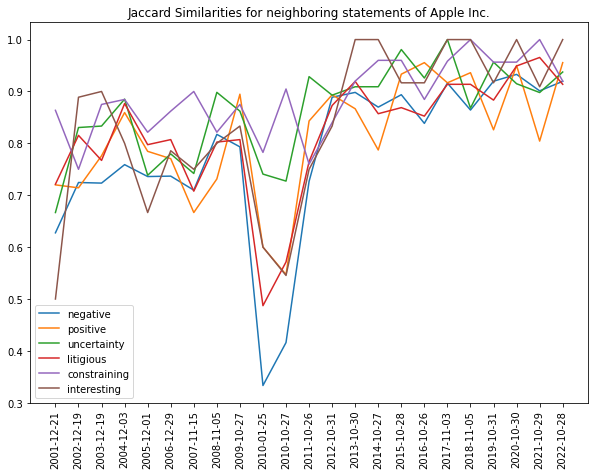

In [ ]:
plot_ls = [jaccard_similarities[company_name][sentiment][::-1] for sentiment in sentiments]
title = 'Jaccard Similarities for neighboring statements of ' + str(company_name)
plt.figure(1, figsize=(10, 7))
for sim, label in zip(plot_ls, sentiments):
    plt.title(title)
    plt.plot(file_dates[1:], sim, label=label)
    plt.legend()
    plt.xticks(rotation=90)

plt.show()

In [ ]:
## Calculate Sentiment TF-IDF for Each Statement
from sklearn.feature_extraction.text import TfidfVectorizer

def calculate_tfidf(sentiments, text_ls):
    vectorizer = TfidfVectorizer(vocabulary=sentiments)
    X = vectorizer.fit_transform(text_ls)
    
    # Remove sentiment words that are not found into document
    # Convert matrix to dataframe and remove all columns that have 0 values for all rows
    df = pd.DataFrame(X.toarray())
    return df.loc[:, (df != 0).any(axis=0)].values

In [ ]:
tfidf_dict = {}

for key, value in text_dic.items():
    tfidf_dict[key] = {sentiment: calculate_tfidf(lm_df[lm_df[sentiment]]['word'], value) for sentiment in sentiments}
tfidf_dict

{'Apple Inc.': {'negative': array([[0.        , 0.        , 0.        , ..., 0.01779849, 0.        ,
          0.0314059 ],
         [0.        , 0.        , 0.        , ..., 0.0174836 , 0.        ,
          0.03085026],
         [0.        , 0.        , 0.        , ..., 0.02638891, 0.        ,
          0.03104262],
         ...,
         [0.02806099, 0.        , 0.        , ..., 0.01165031, 0.04888537,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.00809676, 0.06794898,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.11035642,
          0.        ]]),
  'positive': array([[0.15156041, 0.        , 0.07297678, ..., 0.        , 0.        ,
          0.        ],
         [0.16907244, 0.        , 0.03663399, ..., 0.        , 0.        ,
          0.        ],
         [0.14664947, 0.        , 0.03530608, ..., 0.        , 0.03954837,
          0.        ],
         ...,
         [0.05520663, 0.        , 0.07974646, ...,

In [ ]:
## Calculate the Cosine Similarity for Neighboring Statements
from sklearn.metrics.pairwise import cosine_similarity

def calculate_c_similarity(tfidf):
    
    text_num = len(tfidf)    
    cos_sim_matrix = cosine_similarity(tfidf)
    c_sim = []
    # For each document (row), get the value from cosine similarity matrix for the next document
    for i in range(text_num - 1):
        c_sim.append(cos_sim_matrix[i][i+1])
        
    return c_sim 

In [ ]:
file_dates = list(example_data.filing_date)
file_dates = file_dates[::-1]

cosine_similarities = {}

for key, value in words_bag_dict.items():
    cosine_similarities[key] = {k: calculate_c_similarity(v) for k,v in value.items()}

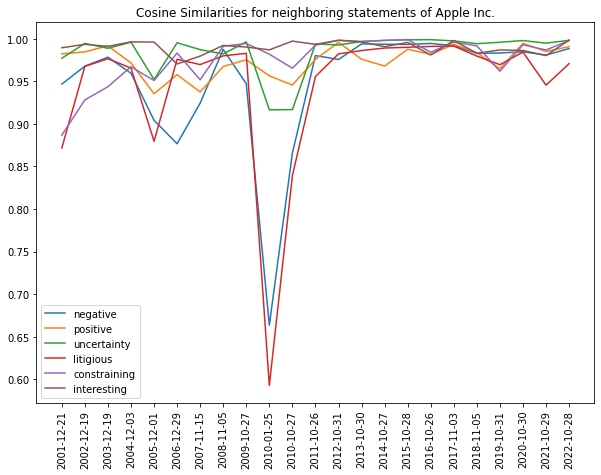

In [ ]:
plot_ls = [cosine_similarities[company_name][sentiment][::-1] for sentiment in sentiments]
title = 'Cosine Similarities for neighboring statements of ' + str(company_name)
plt.figure(1, figsize=(10, 7))
for sim, label in zip(plot_ls, sentiments):
    plt.title(title)
    plt.plot(file_dates[1:], sim, label=label)
    plt.legend()
    plt.xticks(rotation=90)

plt.show()

It can be observed that there are troughs in 2010-01-25 for some sentiment curves in above two pictures. It means that the annual report that submitted at 2010-01-25 has low similarities with its neighbors. The reason may be that the type of annual report submitted at 2010-01-25 is '10-K/A'. 'A' stands for 'Amendment'. It is frequently associated with restatement of financials or missing signatures and exhibits.